In [ ]:
!unzip drive/MyDrive/dataset_zurich.zip

In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cv2
from glob import iglob
import shutil

In [ ]:
DATASET_ROOT = "dataset_zurich/"
NEW_DATASET_ROOT = "data/"

if not os.path.isdir("data"):
		os.mkdir("data")
if not os.path.isdir("data/noninteracting"):
  os.mkdir("data/noninteracting")
if not os.path.isdir("data/merger"):
  os.mkdir("data/merger")

src_train_merger = DATASET_ROOT + "merger/training"
src_val_merger = DATASET_ROOT + "merger/validation"
src_test_merger = DATASET_ROOT + "merger/test"
src_train_noninteracting = DATASET_ROOT + "noninteracting/training"
src_val_noninteracting = DATASET_ROOT + "noninteracting/validation"
src_test_noninteracting = DATASET_ROOT + "noninteracting/test"

dest_merger = NEW_DATASET_ROOT + "merger/"
dest_noninteracting = NEW_DATASET_ROOT + "noninteracting/"

for filename in os.listdir(src_train_merger):
  shutil.move(os.path.join(src_train_merger, filename), dest_merger)
for filename in os.listdir(src_val_merger):
  shutil.move(os.path.join(src_val_merger, filename), dest_merger)
for filename in os.listdir(src_test_merger):
  shutil.move(os.path.join(src_test_merger, filename), dest_merger)

for filename in os.listdir(src_train_noninteracting):
  shutil.move(os.path.join(src_train_noninteracting, filename), dest_noninteracting)
for filename in os.listdir(src_val_noninteracting):
  shutil.move(os.path.join(src_val_noninteracting, filename), dest_noninteracting)
for filename in os.listdir(src_test_noninteracting):
  shutil.move(os.path.join(src_test_noninteracting, filename), dest_noninteracting)

os.rmdir(DATASET_ROOT)  # TODO: Raises error if directory is not empty.

In [3]:
!rm -rf dataset_zurich

In [2]:
original_image = cv2.imread("/content/data/noninteracting/587722952767439411.jpeg")
resized_image = cv2.resize(original_image, (100, 100), 
                           interpolation=cv2.INTER_NEAREST)

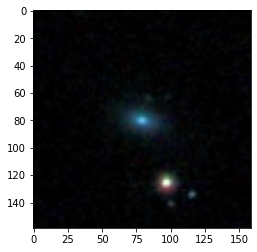

In [3]:
plt.imshow(original_image);

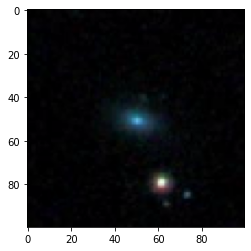

In [4]:
plt.imshow(resized_image);

In [5]:
NEW_DATASET_ROOT = "data"

def num_examples():
	"""Classwise no. of files."""
	sizes = {}
	for class_ in os.listdir(NEW_DATASET_ROOT):
		class_path = os.path.join(NEW_DATASET_ROOT, class_)
		size = len(os.listdir(class_path))
		sizes[class_] = size
	return sizes
sum(num_examples().values())

16000

In [ ]:
NEW_DATASET_ROOT = "data"

def resize(img, size=100):
  """
  size: Final image size (Same for x and y).

  Notes
  -----
  100 is a random choice. Options could be to find the distribution of image sizes in the
  whole dataset and choose a value based on that.

  """
  resized_img = cv2.resize(img, (100, 100))
  return resized_img


# data = np.empty((16000, 100))
size = 100
data = np.empty((0, size*size))
labels = []
for class_ in os.listdir(NEW_DATASET_ROOT):
  class_path = os.path.join(NEW_DATASET_ROOT, class_)
  for image in os.listdir(class_path):
    img = cv2.imread(os.path.join(class_path, image)).mean(axis=2)
    img = resize(img)
    img = img.flatten()
    data = np.append(data, np.expand_dims(img, axis=0), axis=0)
print(data)

In [115]:
data = np.load("flattened_data.npy")

In [116]:
sizes = num_examples()
merger_labels = np.repeat(0, sizes["merger"])
noninteracting_labels = np.repeat(1, sizes["noninteracting"])
labels = np.hstack([merger_labels, noninteracting_labels])  # First write merger labels and then noninteracting because while creating "data", the merger directory gets traversed first, and then noninteracting.

In [117]:
labels

array([0, 0, 0, ..., 1, 1, 1])

In [118]:
data_ = data[:12000]
data_ = (data_ - data_.mean(axis=0)) / data_.std()

In [10]:
np.var(data_)  # TODO: variance must be 1, right??? Mean is close to 0, so that's not a problem

0.6843985816964173

In [ ]:
# NOTE: Uisng the below instead of (x - mean(x)) / std(x) crashes due to full RAM usage.

# from sklearn import preprocessing
# scaler = preprocessing.StandardScaler()
# data_new = scaler.fit_transform(data)

In [11]:
variance = np.sum(np.std(data_, axis = 0) ** 2)
variance

6843.985816964185

In [15]:
from sklearn.decomposition import PCA

explained_variances = {}
num_components = [50, 100, 200, 300]
for num_component in num_components:
  pca = PCA(n_components=num_component)
  tr_d = pca.fit_transform(data_)
  exp_var = np.sum(pca.explained_variance_)
  print(exp_var)
  explained_variances[num_component] = exp_var

4712.1205796849845
5181.516896891113
5611.047808852155
5840.800887866091


In [108]:
pca = PCA(n_components=1024)
tr_d = pca.fit_transform(data_)
exp_var = np.sum(pca.explained_variance_)
print(exp_var)

6413.190235390223


In [110]:
pca

PCA(copy=True, iterated_power='auto', n_components=1024, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [111]:
6413.190235390223/6843.985816964185

0.937054869326855

In [18]:
theoretical_variance = 100*100

In [112]:
var_values = list(explained_variances.values())

In [113]:
explained_variances_percentage = [(var/theoretical_variance) * 100 for var in var_values]

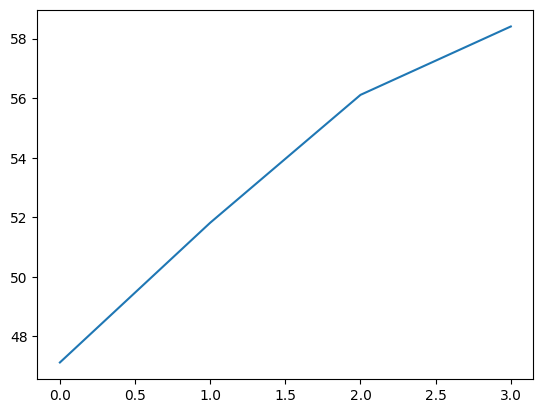

In [114]:
plt.plot(explained_variances_percentage)

In [119]:
img_pcs = pca.transform(data_)

In [120]:
img_pcs.shape

(12000, 1024)

In [121]:
imgs_ = pca.inverse_transform(img_pcs)

In [122]:
imgs_.shape

(12000, 10000)

In [101]:
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

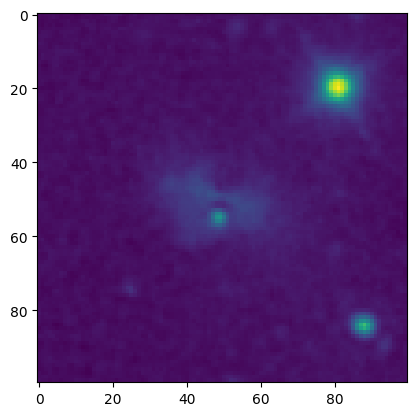

In [123]:
plt.imshow(imgs_[2].reshape(100, 100))

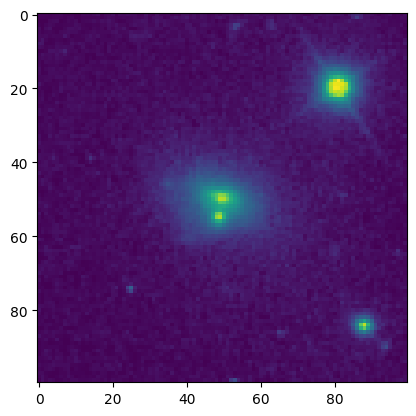

In [124]:
plt.imshow(data[2].reshape(100, 100))

In [125]:
imgs = pca.inverse_transform(img_pcs)  # Use the image PC's to construct images.

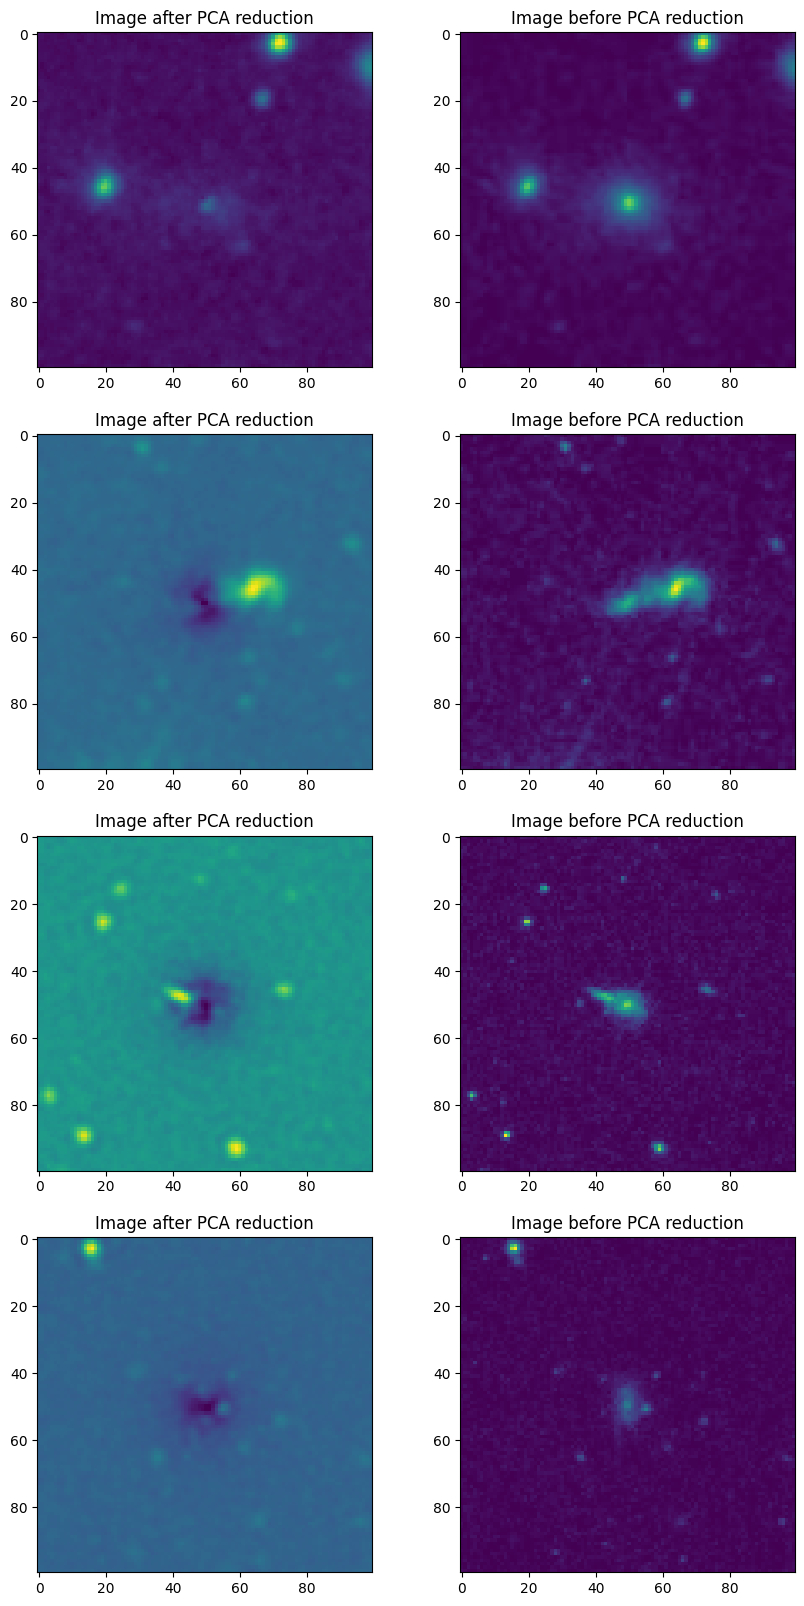

In [126]:
# Show sample images
to_show = 4
index = np.random.choice(imgs.shape[0], to_show, replace=False)
imgs_random = imgs[index]
data_show = data[index]

fig, ax = plt.subplots(nrows=to_show, ncols=2, figsize=(10, 20))
for i in range(len(imgs_random)):
  img = imgs_random[i].reshape(100, 100)  # Since all images are resized to 100 * 100. TODO: Make this robust.
  data_show_img = data_show[i].reshape(100, 100)
  ax[i, 0].imshow(img)
  ax[i, 0].set_title("Image after PCA reduction")
  ax[i, 1].imshow(data_show_img)
  ax[i, 1].set_title("Image before PCA reduction")
plt.show()

In [107]:
fig.savefig("pca_images.png", bbox="tight")

In [89]:
np.save("images_pcs.npy", img_pcs)

In [ ]:
!cp -r images_pcs.npy drive/MyDrive

In [127]:
X = pd.DataFrame(img_pcs)
y = pd.Series(labels)[:12000]

In [128]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle=True, random_state=1)  # shuffle=True is important since the data before splitting consists of all classes' examples together.

In [129]:
pd.Series(y_train).value_counts()

1    4257
0    4143
dtype: int64

In [130]:
# from sklearn.svm import SVC
import xgboost as xgb

In [131]:
# Applying SVM on X_train, y_train data 
# svm = SVC(kernel='linear', probability=True, random_state=42)
# svm.fit(X_train, y_train)
param_dist = {"learning_rate": 0.01, "n_estimators": 600, "reg_lambda": 1e-04, "max_depth": 12, "use_label_encoder": False}  # increasing `max_depth` increases accuracy from ~77 to ~85!
clf = xgb.XGBRFClassifier(**param_dist)
clf.fit(X_train, y_train, verbose=True)  # SEE https://xgboost.readthedocs.io/en/latest/python/python_api.html#xgboost.XGBRegressor.evals_result FOR better options

XGBRFClassifier(base_score=0.5, colsample_bylevel=1, colsample_bynode=0.8,
                colsample_bytree=1, gamma=0, learning_rate=0.01,
                max_delta_step=0, max_depth=12, min_child_weight=1,
                missing=None, n_estimators=600, n_jobs=1, nthread=None,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=0.0001, scale_pos_weight=1, seed=None, silent=None,
                subsample=0.8, use_label_encoder=False, verbosity=1)

In [132]:
# predicting the test dataset values 
y_pred = clf.predict(X_test)

In [133]:
y_pred

array([1, 1, 0, ..., 1, 0, 0])

In [134]:
np.mean(y_pred == y_test)

0.8472222222222222

In [79]:
clf.save_model("xgboost_clf.json")

In [93]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, accuracy_score

In [135]:
accuracy_score(y_test, y_pred)

0.8472222222222222

In [136]:
print(classification_report(y_test, y_pred))
print("\n")
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85      1857
           1       0.82      0.88      0.85      1743

    accuracy                           0.85      3600
   macro avg       0.85      0.85      0.85      3600
weighted avg       0.85      0.85      0.85      3600



[[1521  336]
 [ 214 1529]]


In [137]:
preds_df = pd.DataFrame({"Actual": y_test, "Prediction": y_pred})
preds_df

,Actual,Prediction
7163,1,1
10385,1,1
1902,0,0
3397,0,0
11695,1,1
...,...,...
1973,0,0
5544,0,0
11693,1,1
5477,0,0


In [86]:
!pip install plot-metric

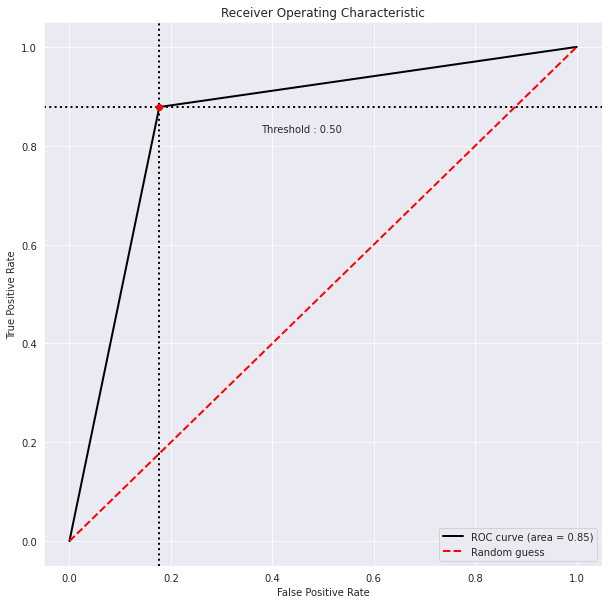

In [87]:
import matplotlib.pyplot as plt
from plot_metric.functions import BinaryClassification

# Visualisation with plot_metric
bc = BinaryClassification(y_test, y_pred, labels=["Class 1", "Class 2"])

# Figures
plt.figure(figsize=(10,10))
bc.plot_roc_curve()
plt.show()